In [1]:
import os
import glob
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import pickle
%matplotlib inline

In [2]:
# read the car and notcar images-name list.
car_list=[name for index,name in enumerate(os.listdir('../vehicles/vehicles')) if index != 0]
noncar_list=[name for index,name in enumerate(os.listdir('../non-vehicles/non-vehicles')) if index != 0]

In [3]:
# load tha cars and notcars images.Using Udacity data.
cars=[]
for carfile in car_list:
    carpath='../vehicles/vehicles/'
    imgpath=os.path.join(carpath+carfile+'/*.png')
    #print(imgpath)
    images=glob.glob(imgpath)
    for image in images:
        cars.append(image)
print(len(cars))

noncars=[]
for carfile in noncar_list:
    carpath='../non-vehicles/non-vehicles/'
    imgpath=os.path.join(carpath+carfile+'/*.png')
    #print(imgpath)
    images=glob.glob(imgpath)
    for image in images:
        noncars.append(image)
print(len(noncars))

8792
8968


car_image min Values is: 4 Car_image Max values is : 255
notcar_image min Values is: 30 notCar_image Max values is : 85


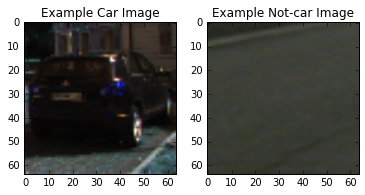

In [4]:
#Visualize the images randomly
#random  choose car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
noncar_ind = np.random.randint(0, len(noncars))
    
# Read in car / not-car images
car_image = cv2.imread(cars[car_ind])
noncar_image = cv2.imread(noncars[noncar_ind])
print('car_image min Values is:',car_image.min(),'Car_image Max values is :',car_image.max())
print('notcar_image min Values is:',noncar_image.min(),'notCar_image Max values is :',noncar_image.max())
# Plot the examples
plt.figure(figsize=(1,1))
fig = plt.figure()
a=fig.add_subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')

a=fig.add_subplot(122)
plt.imshow(noncar_image)
plt.title('Example Not-car Image')

In [5]:
# Define a function to return color_hist HOG features and visualization
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    fhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range) #First channel histogram
    shist = np.histogram(img[:,:,1], bins=nbins, range=bins_range) # Second channel histogram
    thist = np.histogram(img[:,:,2], bins=nbins, range=bins_range) # Third channel histogram
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((fhist[0], shist[0], thist[0]))
    # Return the individual histograms
    return hist_features

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)  # feature_vector=True是不是这里用了numpy拉平？所以返回了ndarray
        return features
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='HSV',spatial_size=(16, 16),hist_bins=32,orient=11,pix_per_cell=16, 
                     cell_per_block=2, hog_channel='ALL',spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'BGR':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image)
            
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_feature=get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True)
                    #print('hog_feature shape is:{},type is{}'.format(hog_feature.shape,type(hog_feature)))
                    hog_features.append(hog_feature)
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

C:\ProgramData\Anaconda3\envs\tf14\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


 No. of features for pix_per_cell-  8 cell_per_block - 1 orient - 9 is 576
 No. of features for pix_per_cell-  16 cell_per_block - 1 orient - 9 is 144
 No. of features for pix_per_cell-  8 cell_per_block - 2 orient - 11 is 2156
 No. of features for pix_per_cell-  16 cell_per_block - 2 orient - 11 is 396


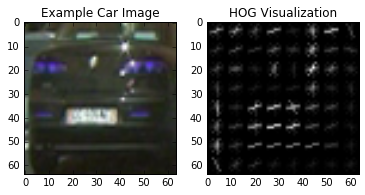

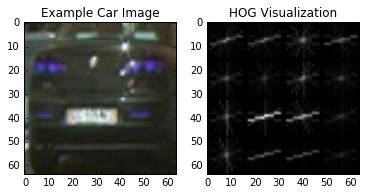

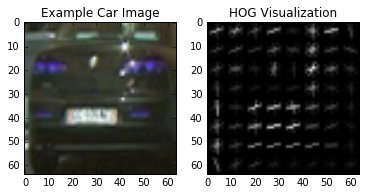

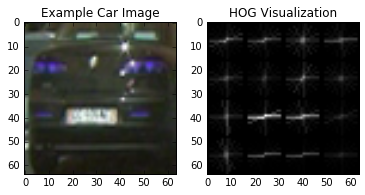

In [6]:
#Extract hog features and display
pix_per_cell = [8,16,8,16]
cell_per_block = [1,1,2,2]
orient = [9,9,11,11]

for i in range(len(pix_per_cell)):
#Input is an image of single channel or gray
    car_ind = 1167
    car_image = cv2.imread(cars[car_ind])

    gray = cv2.cvtColor(car_image, cv2.COLOR_BGR2GRAY)
    features, hog_image = get_hog_features(gray, orient[i], pix_per_cell[i], cell_per_block[i],
                             vis=True, feature_vec=True)
    
    # Plot the examples
    plt.figure(figsize=(1,1))
    fig = plt.figure()
    a=fig.add_subplot(121)
    plt.imshow(car_image, cmap='gray')
    plt.title('Example Car Image')

    a=fig.add_subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization')
    
    print(" No. of features for pix_per_cell- ", pix_per_cell[i], "cell_per_block -", cell_per_block[i],'orient -',orient[i],"is", len(features))

In [7]:
# train the  MLP  classifier model

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"


car_features=extract_features(cars, color_space=color_space,spatial_size=(16, 16),hist_bins=32,orient=11,
                              pix_per_cell=16, cell_per_block=2, hog_channel='ALL')

print('car_features length is:{},第一个feature shape is:{}'.format(len(car_features),car_features[0].shape))

notcar_features=extract_features(noncars, color_space=color_space,spatial_size=(16, 16),hist_bins=32,orient=11,
                              pix_per_cell=16, cell_per_block=2, hog_channel='ALL')

print('car_features length is:{},第一个feature shape is:{}'.format(len(notcar_features),notcar_features[0].shape))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
print('X shape is:{},X min is {},X max is {}'.format(X.shape,X.min(),X.max()))

#  Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=rand_state)
print('X_train min value is {},X_train max value is {}'.format(X_train.min(),X_train.max()))    
print('X_test min value is {},X_test max value is {}'.format(X_test.min(),X_test.max()))   
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('---After StandardScaler---  X_train min value is {},X_train max value is {},Mean is {}'.
      format(X_train.min(),X_train.max(),X_train.mean()))    
print('---After StandardScaler---  X_test min value is {},X_test max value is {},Mean is {}'.
      format(X_test.min(),X_test.max(),X_train.mean()))  

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use MLPclassifier train the model
hidden_nodes=(1000,200)
learn_rate=0.001
mlp=MLPClassifier(hidden_layer_sizes=hidden_nodes,activation='logistic',learning_rate_init=learn_rate,
                          verbose=True,early_stopping=True)
# Check the training time for the MLP
t=time.time()
mlp.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train MLP...')
# Check the score of the MLP
print('Test Accuracy of MLP = ', round(mlp.score(X_test, y_test), 4))

C:\ProgramData\Anaconda3\envs\tf14\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


car_features length is:8792,第一个feature shape is:(2052,)
car_features length is:8968,第一个feature shape is:(2052,)
X shape is:(17760, 2052),X min is 0.0,X max is 4096.0
X_train min value is 0.0,X_train max value is 4096.0
X_test min value is 0.0,X_test max value is 4096.0
---After StandardScaler---  X_train min value is -14.101263969475347,X_train max value is 119.19312060685856,Mean is 7.818627157333775e-17
---After StandardScaler---  X_test min value is -13.180095249174855,X_test max value is 61.22975471314555,Mean is 7.818627157333775e-17
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2052
Iteration 1, loss = 0.08814235
Validation score: 0.992259
Iteration 2, loss = 0.01856582
Validation score: 0.992963
Iteration 3, loss = 0.00906270
Validation score: 0.994370
Iteration 4, loss = 0.00500036
Validation score: 0.993666
Iteration 5, loss = 0.00410535
Validation score: 0.995074
Iteration 6, loss = 0.00186101
Validation score: 0.995074
Iteration 7, lo

In [8]:
import pickle
# Save the mlp and X_scaler
dist_pickle = {}
dist_pickle["mlp"] = mlp
dist_pickle["X_scaler"] =X_scaler
pickle.dump( dist_pickle, open( "../mlp_pickle.p", "wb" ) )

In [6]:
# Define function to find cars
def convert_color(img, conv='BGR2YCrCb'):
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif conv == 'BGR2LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif conv == 'BGR2HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif conv == 'BGR2HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif conv == 'BGR2YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler,spatial_size,hist_bins, orient, pix_per_cell, 
              cell_per_block,conv='BGR2YUV'):
    
    draw_img = np.copy(img)
    heatmap=np.zeros_like(img[:,:,0])
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ## convert color space function 
    ctrans_tosearch = convert_color(img_tosearch, conv=conv)
    # scale=the origin scaled ratio
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step 
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    # define the bbox_list for detect False positive and heat map
    bbox_list=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features,hist_features,hog_features)).reshape(1,-1))   
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw] += 1
                
    return draw_img,heatmap,bbox_list

C:\ProgramData\Anaconda3\envs\tf14\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


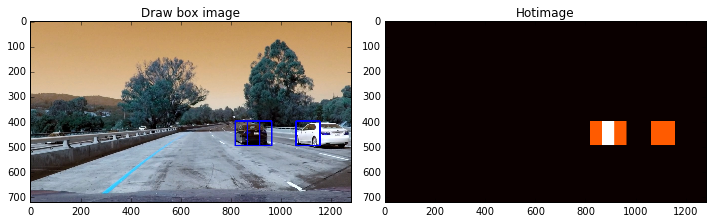

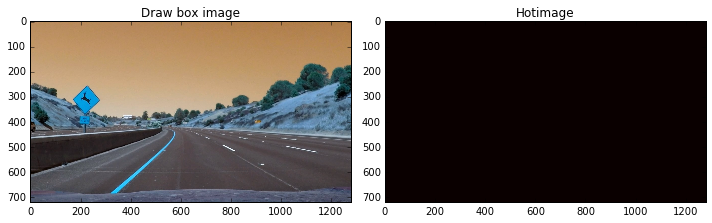

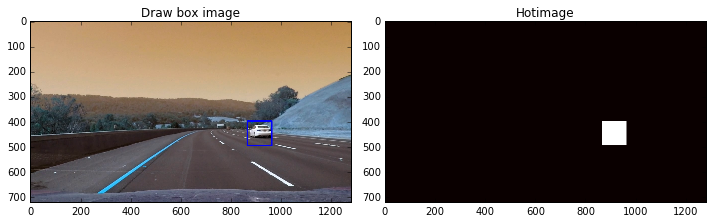

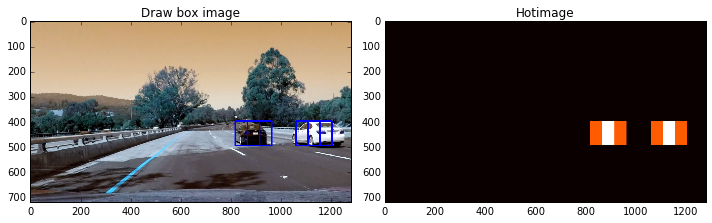

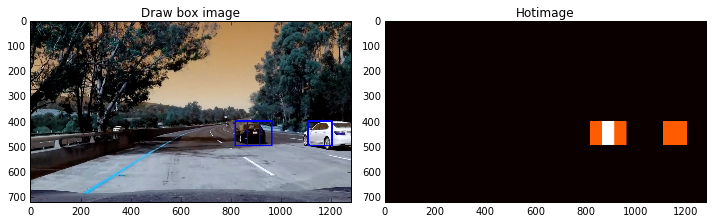

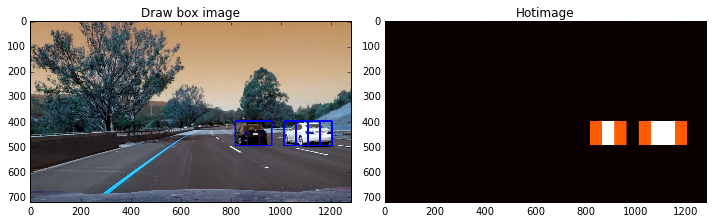

In [10]:
spatial_size=(16, 16)
hist_bins=32
ystart=400
ystop=660
orient=11
pix_per_cell=16
cell_per_block=2
scale=1.5
images=glob.glob('../test_images/test*.jpg')
for fname in images:
    img=cv2.imread(fname)
    draw_img,heatmap,bbox_list=find_cars(img, ystart, ystop, scale, mlp, X_scaler,spatial_size,hist_bins, orient, 
                                     pix_per_cell, cell_per_block,conv='BGR2YUV')
    
    fig = plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Draw box image')
    
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Hotimage')
    fig.tight_layout()

In [7]:
## Multiple Detections & False Positives 
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def detect_false_and_applyto_origin(img,box_list,threshold=1,draw_pic=False):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    if draw_pic==True:
        plt.figure(figsize=(10,10))
        fig = plt.figure()

        plt.imshow(draw_img)
        plt.show()
    return draw_img

C:\ProgramData\Anaconda3\envs\tf14\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


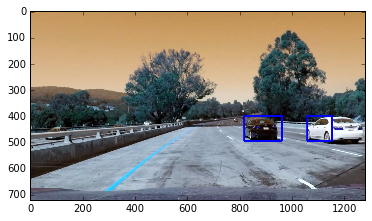

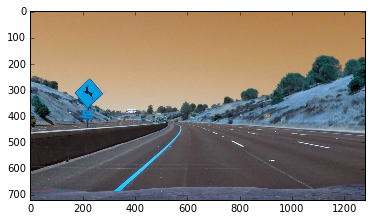

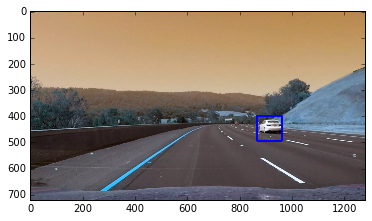

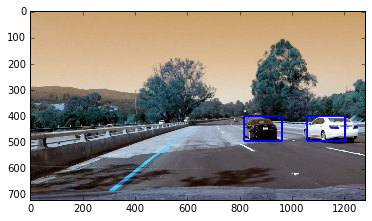

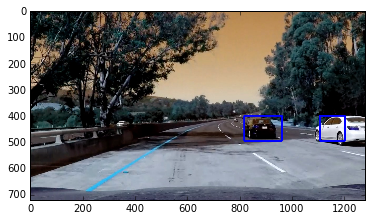

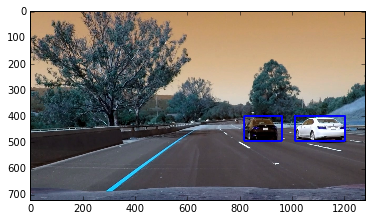

In [12]:
spatial_size=(16, 16)
hist_bins=32
ystart=400
ystop=660
orient=11
pix_per_cell=16
cell_per_block=2
scale=1.5
images=glob.glob('../test_images/test*.jpg')
for fname in images:
    img=cv2.imread(fname)
    draw_img,heatmap,bbox_list=find_cars(img, ystart, ystop, scale, mlp, X_scaler,spatial_size,hist_bins, orient, 
                                     pix_per_cell, cell_per_block,conv='BGR2YUV')
    result=detect_false_and_applyto_origin(img,bbox_list,threshold=0.8,draw_pic=True)

In [12]:
def process_image(img,n_frames=20, thresholding=18):
    spatial_size=(16, 16)
    hist_bins=32
    ystart=400
    ystop=660
    orient=11
    pix_per_cell=16
    cell_per_block=2
    scale=1.5
    
    f=open("../mlp_pickle.p", "rb" )
    dist_pickle=pickle.load(f)
    mlp=dist_pickle['mlp']
    X_scaler=dist_pickle["X_scaler"]

    bbox_list_temp =[]
    global hot_windows_list
    global bbox_list
    global bbox_list_final

    draw_img,heatmap,bbox_list=find_cars(img, ystart, ystop, scale, mlp, X_scaler,spatial_size,hist_bins, orient, 
                                     pix_per_cell, cell_per_block,conv='BGR2YUV')
    
    hot_windows_list.append(bbox_list)
   
    if len(hot_windows_list) <= n_frames:
         bbox_list_final = sum(hot_windows_list, []) # Add windows from all available frames
    
    #Look at last n frames and append all hot windows found
    else: 
        for val in hot_windows_list[(len(hot_windows_list) - n_frames -1) : (len(hot_windows_list)-1)]:
            bbox_list_temp.append(val)
        #Flatten this list
        bbox_list_final = sum(bbox_list_temp, [])
        
    result=detect_false_and_applyto_origin(img,bbox_list_final,threshold=thresholding,draw_pic=False)
    
    return result

In [13]:
hot_windows_list = []

from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
#video = VideoFileClip("../project_video.mp4").subclip(0,18)
video = VideoFileClip("../project_video.mp4")

project_clip = video.fl_image(process_image) #NOTE: this function expects color images!!

output = "../vehicle_detection.mp4"
%time project_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ../vehicle_detection.mp4
[MoviePy] Writing video ../vehicle_detection.mp4


100%|███████████████████████████████████████▉| 450/451 [02:47<00:00,  2.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../vehicle_detection.mp4 

Wall time: 2min 48s


In [14]:
output = "../MLP-2018vehicle_detection.mp4"
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

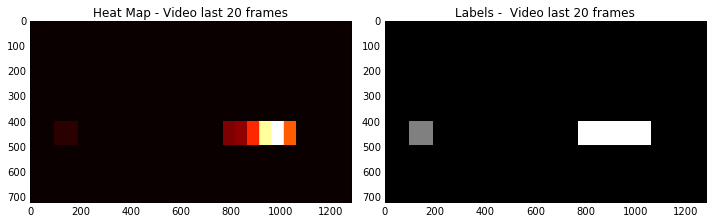

In [15]:
# Add heat to each box in box list
image = cv2.imread('../test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

heat = np.zeros_like(image[:,:,0]).astype(np.float)

heat = add_heat(heat,bbox_list_final)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)


fig = plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map - Video last 20 frames')
    
plt.subplot(122)
plt.imshow(labels[0], cmap='gray')
plt.title('Labels -  Video last 20 frames')
    
fig.tight_layout()